In [1]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=0c76b7dfef5094da18c65aad5a85ac020a761609d19588d8e2a05bf6aea99ec7
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Unix-like
Mounted at /content/drive
Cloning into 'HeartRateRegression'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 997 (delta 186), reused 145 (delta 75), pack-reused 719
Receiving objects: 100% (997/997), 88.29 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (642/642), done.
Already up to date.
Already up to date.


In [2]:
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds()

cuda


In [3]:
from data_utils import (FormatIeee,  IeeeExtractorTest)

SUBJECTS = list(range(1,10))

extractor = IeeeExtractorTest(DATA_DIR)
formatter = FormatIeee()
dfs_train = [formatter.transform(extractor.extract_subject(i)) for i in SUBJECTS]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


In [4]:
git_pull()

import importlib

import PPG

from PPG import FullTrainer

importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(PPG.NoHrPceLstmModel)
importlib.reload(PPG.TrainerXY)
importlib.reload(PPG.TrainerIS)
importlib.reload(PPG.FullTrainer)


Already up to date.


<module 'PPG.FullTrainer' from '/tmp/HeartRateRegression/PPG/FullTrainer.py'>

subject: 0
TS:(34.243748, 34.24416)
subject: 1
TS:(9.542508, 10.036457)
subject: 2
TS:(5.941139, 9.696876)
subject: 3
TS:(47.525837, 47.525833)
subject: 4
TS:(7.2777333, 8.263368)
subject: 5
TS:(22.532728, 22.706371)
subject: 6
TS:(17.04495, 20.474722)
subject: 7
TS:(8.2901125, 8.493531)
subject: 8
TS:(3.5474403, 6.5987964)
subject: 9
TS:(5.7197104, 11.083268)


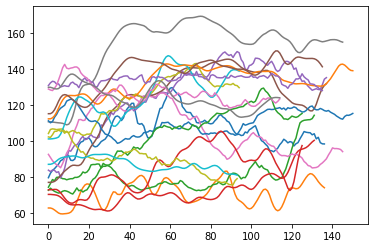

In [10]:
import matplotlib.pyplot as plt
import pickle
# fchoice = {'val_sub': 4,
#   'ts_sub': 0,
#   'batch_size': 64,
#   'weight_decay': 0,
#   'lr': 0.001,
#   'nattrs': 5,
#   'bvp_count': 16,
#   'dropout_rate': 0.25,
#   'lstm_input': 128,
#   'lstm_size': 64,
#   'ts_h_size': 64
#   }
def compute_ensemble(results):
  ps = np.stack([v["predictions"][1].reshape(-1).numpy() for v in results])
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]

  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  e = ps - y

  plt.plot(a)
  plt.plot(y)

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps-y))


fchoice = {'val_sub': 4,
  'ts_sub': 0,
  'batch_size': 64,
  'weight_decay': 0.0001,
  'lr': 0.001,
  'nattrs': 6,
  'bvp_count': 12,
  'dropout_rate': 0,
  'lstm_input': 128,
  'lstm_size': 32,
  'ts_h_size': 32
  }



from PPG import UtilitiesDataXY


aresults = list()
for ts_sub in [0,1,2,3, 4,5,6,7,8,9]:
  dresults = list()
  for i in range(7):
    filename = f"ieee_test_ts_{ts_sub}_{i}_pce_lstm_12.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = FullTrainer.IeeeJointValNoHrPceLstmFullTrainer(dfs_train, args["device"], nrun=400)
    else:
      dresults.append(out)
      continue
    # try:
    fchoice["ts_sub"] = ts_sub
    out = full_trainer.train(**fchoice)
    print(out["args"], out["metric"])
    dresults.append(out)
    with open(save_path, "wb") as f:
      pickle.dump(out, f)
    # except RuntimeError as e:
    #   if isinstance(e, KeyboardInterrupt):
    #     raise e
    #   else:
    #     print("####")
    #     print(f"Failed: {choice}")
    #     print("###")
  print(f"subject: {ts_sub}")
  print(f"TS:{compute_ensemble(dresults)}")
  aresults.append(dresults)
